# Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.data.experimental import AUTOTUNE
import numpy as np
import time
import PIL

# Dataset Creation

In [2]:
IMAGE_SIZE=32
IMAGE_CHANNELS=3
BATCH_SIZE = 32

# function to preprocess images
def preprocess(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # load the image as uint8 array and transform to grayscale
    img = tf.image.decode_png(img, channels=IMAGE_CHANNELS)
    # resize the image to the desired size
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    # transform the color values from [0, 255] to [-1, 1]. The division changes the datatype to float32
    img = (img - 127.5) / 127.5
    return img

Check one image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)


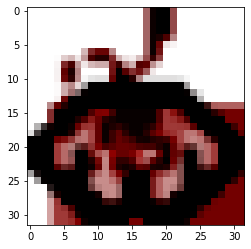

In [27]:
img=preprocess('/content/drive/MyDrive/Binding_of_Isaac_monsters/binding_of_Isaac_4.png')
plt.imshow(img)
print(img.shape)

In [4]:
# function for dataset performance
def ds_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=300)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(1)
    return ds

In [5]:
# creating the dataset
# Get all images from subfolders
list_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/Binding_of_Isaac_monsters/*')
train_dataset = list_ds.take(-1)
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.  
train_dataset = list_ds.map(preprocess,num_parallel_calls=AUTOTUNE)
train_dataset = ds_performance(train_dataset)

In [6]:
len(list(train_dataset.as_numpy_iterator()))

9

# Generator model

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(IMAGE_CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape==(None,32,32,3)

    return model

In [8]:
generator=make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

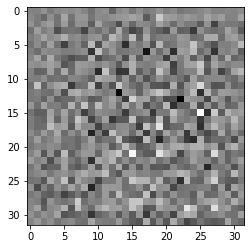

In [9]:
# test the generator
noise=tf.random.normal([1,100])
generated_images=generator(noise,training=False)
plt.imshow(generated_images[0,:,:,0],cmap='gray')

# Discriminator model

In [10]:
def disc_model():
  model=tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[32, 32, 3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1,activation='sigmoid'))

  return model

discriminator=disc_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [11]:
# let's classify one image generated by our generator
predictions=discriminator(generated_images)
print(predictions)

tf.Tensor([[0.4989928]], shape=(1, 1), dtype=float32)


# Compile models

In [12]:
# create the GAN
gan=tf.keras.models.Sequential([generator,discriminator])

In [13]:
optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer)
discriminator.trainable=False
gan.compile(loss='binary_crossentropy',optimizer=optimizer)

# Generate and save images

In [14]:
seed=tf.random.normal([16,100])

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :] * 0.5 + 0.5)
      plt.axis('off')

  plt.savefig(f'image_at_epoch_{epoch}.png')
  plt.show()

# Train GAN

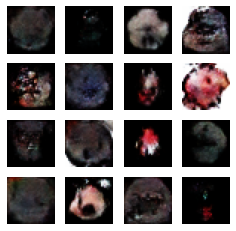

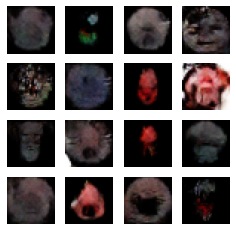

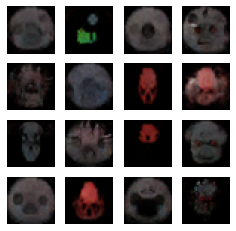

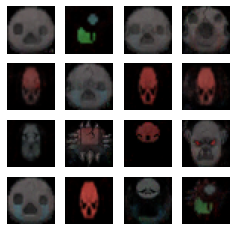

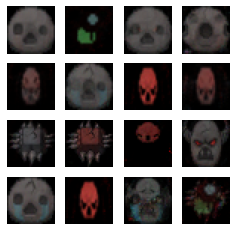

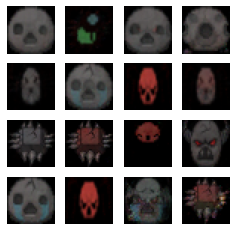

In [15]:
def train_gan(gan,dataset,batch_size,n_epochs=30000):
  generator,discriminator=gan.layers

  for epoch in range(n_epochs):
    start = time.time()

    for X_batch in dataset:

      # training the discriminator
      noise= tf.random.normal([batch_size,100])
      generated_images=generator(noise)
      fake_real_images=tf.concat([generated_images,X_batch],axis=0)
      y_disc=tf.constant([[0.]]*batch_size+[[1.]]*batch_size)
      discriminator.trainable=True
      discriminator.train_on_batch(fake_real_images,y_disc)

      # training the generator
      noise=tf.random.normal([batch_size,100])
      y_gen=tf.constant([[1.]]*batch_size)
      discriminator.trainable=False
      gan.train_on_batch(noise,y_gen)

    #print (f'Time for epoch {epoch + 1} is {time.time()-start} sec')
    if (epoch+1)%5000==0:
      generate_and_save_images(generator, epoch,seed)

train_gan(gan,train_dataset,BATCH_SIZE)

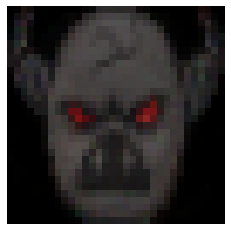

In [23]:
predictions = generator(seed, training=False)

fig = plt.figure(figsize=(4,4))



plt.imshow(predictions[11, :, :] * 0.5 + 0.5)
plt.axis('off')

plt.savefig(f'head1.png')
plt.show()


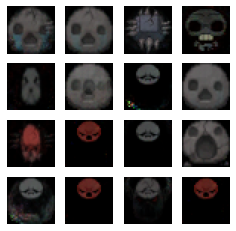

In [38]:
seed=tf.random.normal([16,100])
generate_and_save_images(generator, 1, seed)

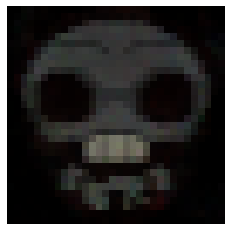

In [29]:
predictions = generator(seed, training=False)

fig = plt.figure(figsize=(4,4))



plt.imshow(predictions[0, :, :] * 0.5 + 0.5)
plt.axis('off')

plt.savefig(f'monster2.png')
plt.show()